In [7]:
from src.utils.results_utils import *

from src.utils.data_utils import str_dict_to_values

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

In [9]:
df_char_cleaned = pd.read_csv('data/cleaned.csv')

df_char_cleaned['Languages'] = df_char_cleaned['Languages'].apply(str_dict_to_values)
df_char_cleaned['Country'] = df_char_cleaned['Country'].apply(str_dict_to_values)
df_char_cleaned['Genres'] = df_char_cleaned['Genres'].apply(str_dict_to_values)

## Presenting the Data

In [10]:
df_char_cleaned.head()

,Wikipedia_ID,Name,Languages,Country,Genres,Character_name,Sex,Actor_age,Release_date
0,975900,Ghosts of Mars,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Akooshay,F,42.0,2001-08-24
1,975900,Ghosts of Mars,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Melanie,F,27.0,2001-08-24
2,975900,Ghosts of Mars,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Williams,M,32.0,2001-08-24
3,975900,Ghosts of Mars,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Jericho,M,33.0,2001-08-24
4,975900,Ghosts of Mars,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Bashira,F,23.0,2001-08-24


In [11]:
name_count = df_char_cleaned['Character_name'].nunique()
movie_count = df_char_cleaned['Wikipedia_ID'].nunique()

summary_df = pd.DataFrame({
    '': ['Unique Character Names', 'Unique Movies'],
    'Count': [name_count, movie_count]
})

summary_df.head()

,,Count
0,Unique Character Names,38401
1,Unique Movies,31103


In [ ]:
name_counts = df_char_cleaned['Character_name'].value_counts()
top_100_names = name_counts.head(1000)

# Creating the interactive line plot with hover information
fig = go.Figure()

# Adding trace for the line plot with hover text
fig.add_trace(go.Scatter(
    x=top_100_names.index,
    y=top_100_names.values,
    mode='lines+markers',
    name='Character Count',
    line=dict(color='skyblue'),
    hovertext=[f"Name: {name}<br>Count: {count}" for name, count in zip(top_100_names.index, top_100_names.values)],
    hoverinfo="text"
))

# Setting up layout for the figure
fig.update_layout(
    title='Count of Most Popular Character Names',
    xaxis_title='Character Name',
    yaxis_title='Count',
    xaxis=dict(tickangle=45)
)

fig.show()

## Movie Genre Analysis

In [ ]:
#Let's make a list of the genres we are interested in and assign one of them to each character
genres_list = ['Action & Adventure', 'Drama', 'Comedy', 'Horror & Thriller', 
              'Fantasy & Sci-Fi', 'Historical & War', 'Romance', 'Documentary', 
              'Music & Performance', 'Cult & B-Movies', 'Other']
df_char_cleaned['Genre_Category'] = df_char_cleaned['Genres'].apply(lambda x: categorize_genre(x))

In [ ]:
#Let's see the most frequent names in each genre and for each gender
frequent_names_m, frequent_names_f = get_top_names_by_genre(df_char_cleaned,5)

In [ ]:
data_f = create_sunburst_data(frequent_names_f)
data_m = create_sunburst_data(frequent_names_m)

In [ ]:
# Create the sunburst plots for females and males
fig_females = go.Figure(go.Sunburst(
    labels=data_f['character'],
    parents=data_f['parent'],
    domain=dict(column=1),
    maxdepth=2
))

fig_males = go.Figure(go.Sunburst(
    labels=data_m['character'],
    parents=data_m['parent'],
    domain=dict(column=1),
    maxdepth=2
))

# Create a subplot with 1 row and 2 columns
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=["Females", "Males"],
    specs=[[{"type": "sunburst"}, {"type": "sunburst"}]]
)

# Add the sunburst charts to the subplots
fig.add_trace(fig_females['data'][0], row=1, col=1)
fig.add_trace(fig_males['data'][0], row=1, col=2)

# Update the layout for the subplot
fig.update_layout(
    title_text="Comparison of Names by Gender",
    showlegend=False,
    width=1600,  # Width of the figure in pixels
    height=800,  # Height of the figure in pixels
    font=dict(size=13),  # Global font size, will affect other texts like titles
)

# Display the plot
fig.show()

In [ ]:
# Looking for the appearance of all the character with a name starting by the selected string

genre_counts_result, movies_with_name = count_name_appearance_by_genre(df_char_cleaned, genres_list, 'Leo')
genre_counts_result.head(15)

,Genre_Category,Count
0,Action & Adventure,166
1,Drama,250
2,Comedy,142
3,Horror & Thriller,111
4,Fantasy & Sci-Fi,66
5,Historical & War,56
6,Romance,84
7,Documentary,21
8,Music & Performance,15
9,Cult & B-Movies,49


In [ ]:
movies_with_name.head(5)

,Wikipedia_ID,Name,Languages,Country,Genres,Character_name,Sex,Actor_age,Release_date,Genre_Category
83,27611999,Special Effects,[],"[United States of America, United Kingdom]","[Thriller, Horror, Psychological thriller, Sus...",Leon,NaN,NaN,1984,"[Action & Adventure, Horror & Thriller, Drama,..."
466,21271533,Bleeder,[Danish Language],[Denmark],"[Thriller, Drama]",Leo,M,34.0,1999-08-06,"[Action & Adventure, Horror & Thriller, Drama]"
573,17379289,Without Warning,[English Language],[United States of America],"[Science Fiction, Horror]",Leo,M,60.0,1980-11-26,"[Fantasy & Sci-Fi, Horror & Thriller]"
637,13911991,A Sereia de Pedra,[French Language],"[France, Portugal]","[Silent film, Drama]",Leonor,F,NaN,1923-04-02,[Drama]
1799,20927265,Camões,[Portuguese Language],[Portugal],"[Biography, Drama]",Leonor,F,24.0,1946-09-20,"[Documentary, Drama]"


On va 

In [ ]:
def calculate_column_freq(df, column_name='Character_name'):
    """
    Calculate the count and frequency (percentage) of unique values in a specified column.
    """
    # Calculating the total number of entries in the specified column
    total_entries = df[column_name].count()
    
    # Counting occurrences of each unique value
    counts_df = df[column_name].value_counts().reset_index()
    counts_df.columns = [column_name, 'Count']
    
    # Adding a frequency column with the count divided by the total number of names, expressed as a percentage
    counts_df['Frequency (%)'] = counts_df['Count'] / total_entries * 100
    
    return counts_df

In [ ]:
df_char_cleaned.head()

Chi2 Stat: 11363.347871189899
P-Value: 1.0
Degrees of Freedom: 20830
Expected Frequencies:
[[0.61553661 0.38446339]
 [0.61553661 0.38446339]
 [0.61553661 0.38446339]
 ...
 [0.61553661 0.38446339]
 [0.61553661 0.38446339]
 [1.23107321 0.76892679]]


In [ ]:
df_expanded = df_char_cleaned.explode('Genre_Category')


contingency_table = create_contingency_table(df_expanded,'Character_name','Genre_Category')
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}")
print(f"p-value: {p_value}")

Chi-Square Statistic: 407882.06544038316
p-value: 1.7570105040794593e-295


The p-value is very close to zero, hence we can say taht there is an association between character names and genres. We will now try to quantify this association using Cramér's V.

In [ ]:
n = contingency_table.sum().sum()
k = min(contingency_table.shape)
cramers_v = np.sqrt(chi2 / (n * (k - 1)))

print(f"Cramér's V: {cramers_v}")

Cramér's V: 0.35238075183530704


The Cramér's V is close to 0.35, meaning there is a moderate association between genres and character names.

## Gender Analysis

In [ ]:
df_vowels, df_consonants = get_vowel_stats(df_char_cleaned)

Stats for vowels in character names by sex:


,mean,std
Sex,,
F,2.633991,0.827407
M,2.305355,0.890816


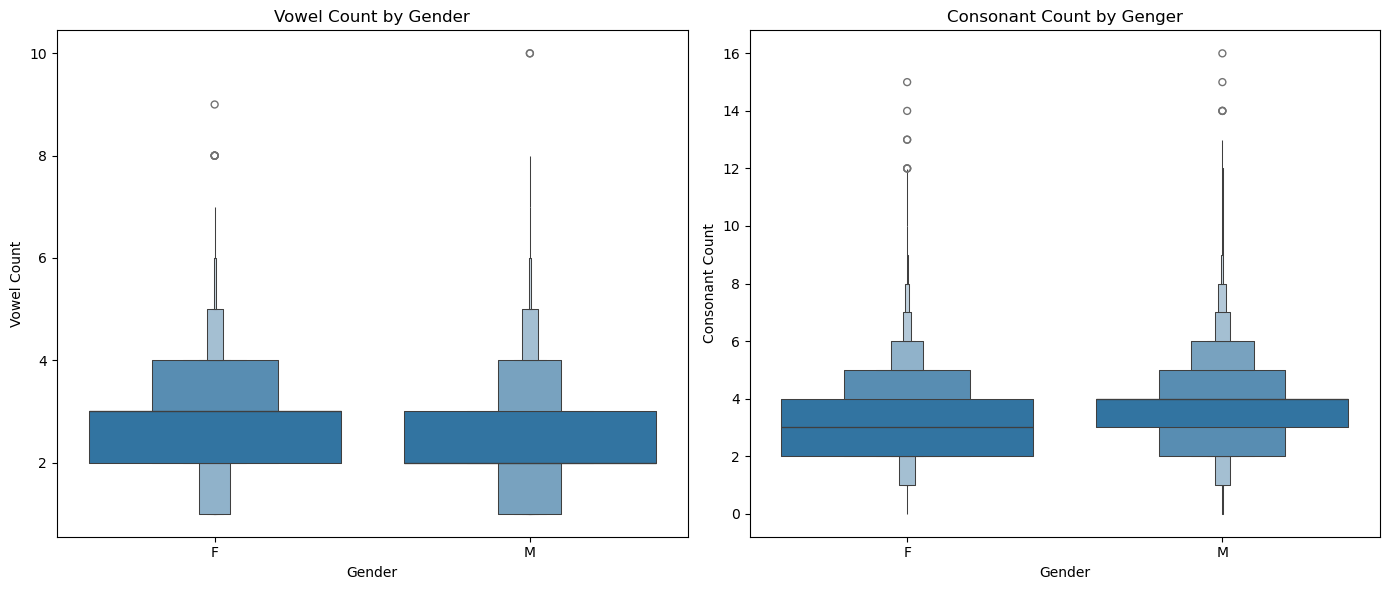

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot for vowel count by sex
sns.boxenplot(data=df_char_cleaned, x='Sex', y='vowel_count', ax=axes[0])
axes[0].set_title('Vowel Count by Gender')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Vowel Count')

# Boxplot for consonant count by sex
sns.boxenplot(data=df_char_cleaned, x='Sex', y='consonant_count', ax=axes[1])
axes[1].set_title('Consonant Count by Genger')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Consonant Count')

plt.tight_layout()

In [ ]:
df_length = get_length_stats(df_char_cleaned)

print('Length stats for character names by sex:')
df_length.head()

Length stats for character names by sex:


,mean,std
Sex,,
F,6.060847,1.653263
M,6.078445,1.849723


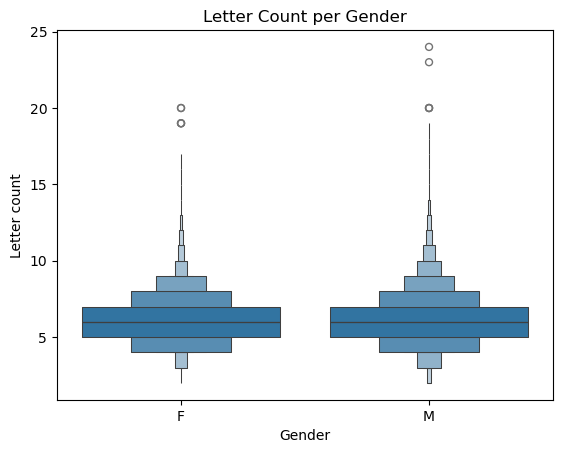

In [ ]:
create_boxenplot_by_sex(df_char_cleaned)

In [ ]:
plot_letter_name_percentage(df_char_cleaned, 0)
plot_letter_name_percentage(df_char_cleaned, -1)

#### Analysis of the age distribution of the female and male names, with the most frequent names for each category

In [ ]:
plot_age_sex_distribution_with_top_names(df_char_cleaned)

## Country Analysis

In [ ]:
countries_code = []

df_continent = create_continent_df(df_char_cleaned,countries_code)
print(df_continent)

       Continent Female_name Male_name
0         Africa      Amina*     Omar*
1           Asia       Priya     Vijay
2         Europe        Anna      John
3  North America       Sarah      John
4        Oceania       Angie      John
5  South America       Maria      João


\* 3 other names are in a tie for this category. We choose to display only one name for readability

In this table we see the most recurrent character names for each continent. For Asia, we see that the most common names are indian names. Is it because other nearby countries are influenced by the bollywood industry or because India's movies are predominent in this dataset? 
We will try to answer the question by plotting the most common character names per country and reting it with the number of movies from this country in the dataset.

In [ ]:
df_top_names = create_top_names_df(df_char_cleaned)
add_movie_count(df_char_cleaned,df_top_names)

In [ ]:
df_top_names = cleaning_non_countries(df_top_names)

In [ ]:


fig = go.Figure(go.Scattergeo(
))
fig.add_trace(go.Choropleth(
    locations= df_top_names['primary_country'],
    locationmode='country names',
    showscale= True,
    colorscale='YlOrRd',
    z=np.log10(df_top_names['Number_of_movies']),
    colorbar=dict(title="Number of movies (Log Scale)", tickvals=np.arange(0, 5), ticktext=[f"10^{i}" for i in range(0, 5)]),
    text= [f"Top female name: {female}<br>Top male name: {male}<br>Movies: {movies:,}" 
           for female, male, movies in zip(df_top_names['Female_name'], df_top_names['Male_name'], df_top_names['Number_of_movies'])],
    hovertemplate="%{location}<br>%{text}"
))
fig.update_geos(
    projection_scale=1,center={'lat': 30},
    visible=False,
    showcountries=True, countrycolor="RebeccaPurple"
)
fig.update_layout(
    geo=dict(
        projection_type="mercator",
        lakecolor="aqua"
    ),
    height=500,
    margin={"r":0,"t":5,"l":0,"b":0},
    title_text="Most Common Male and Female Character Names by Country",
    title_x=0.4,
    title_y=0.90
)
fig.show()

In [ ]:
# Chi2
contingency_table = create_contingency_table(df_char_cleaned,'Character_name','primary_country')
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}")
print(f"p-value: {p_value}")

Chi-Square Statistic: 7181854.659529755
p-value: 0.0


We see that we have a p-value equal to 0, meaning that there is a statistically significant association between the country of movie production and the character names in the movie. We will now investigate the strength of this association using Cramér's V.

In [ ]:
n = contingency_table.sum().sum()
k = min(contingency_table.shape)
cramers_v = np.sqrt(chi2 / (n * (k - 1)))

print(f"Cramér's V: {cramers_v}")

Cramér's V: 0.7202848738656566


The Cramér's V is superior to 0.5 meaning that there is a strong association between the country of production of the movie and the name of the characters in the movies.